<a href="https://colab.research.google.com/github/spdin/time-series-prediction-lstm-pytorch/blob/master/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Library

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

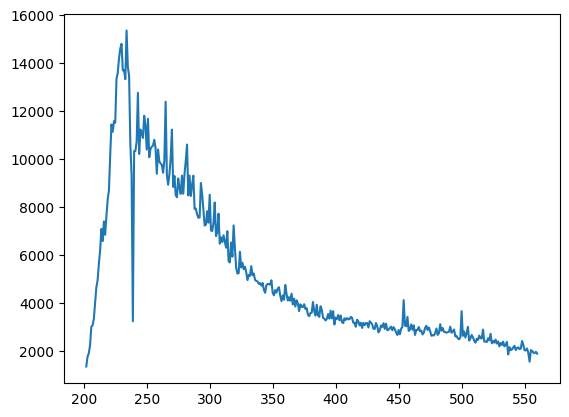

In [52]:
training_set = pd.read_csv('Wordle.csv')

training_set_x = training_set.loc[:,['Contest number']].values
training_set_y = training_set.loc[:,['Number in hard mode']].values

training_set = training_set.loc[:,['Number in hard mode']].values

plt.plot(training_set_x, training_set_y, label = 'Wordle Data')
plt.show()

## Dataloading

In [53]:
data = training_set_y
data = (data - data.mean(axis=0)) / data.std(axis=0)
data

array([[-1.18156732],
       [-1.05475683],
       [-1.00732148],
       [-0.90327996],
       [-0.65819734],
       [-0.64048815],
       [-0.55447206],
       [-0.35208125],
       [-0.14020338],
       [-0.04533269],
       [ 0.17128872],
       [ 0.35027809],
       [ 0.63109533],
       [ 0.47139634],
       [ 0.73070956],
       [ 0.55393384],
       [ 0.80059763],
       [ 1.01785151],
       [ 1.14149965],
       [ 1.60162249],
       [ 2.00893399],
       [ 1.91311459],
       [ 2.05352321],
       [ 2.03201919],
       [ 2.60851675],
       [ 2.69042178],
       [ 2.87984692],
       [ 3.00760612],
       [ 3.07211819],
       [ 2.72267781],
       [ 2.7252077 ],
       [ 2.6063031 ],
       [ 3.2479452 ],
       [ 2.76631833],
       [ 2.65057609],
       [ 1.74962077],
       [ 1.3318735 ],
       [-0.58483068],
       [ 1.65854491],
       [ 1.65854491],
       [ 1.78409045],
       [ 2.42510008],
       [ 1.61964792],
       [ 1.9425245 ],
       [ 1.89603787],
       [ 1

## Model

In [54]:
inp_dim = 1
out_dim = 1
mid_dim = 8
mid_layers = 1
batch_size = 12 * 4
mod_dir = '.'

data_x = data[:-1, :]
data_y = data[+1:, 0]

train_size = int(len(data_x) * 0.75)

train_x = data_x[:train_size]
train_y = data_y[:train_size]
train_x = train_x.reshape((train_size, inp_dim))
train_y = train_y.reshape((train_size, out_dim))

In [55]:
class RegLSTM(nn.Module):
    def __init__(self, inp_dim, out_dim, mid_dim, mid_layers):
        super(RegLSTM, self).__init__()

        self.rnn = nn.LSTM(inp_dim, mid_dim, mid_layers)  # rnn
        self.reg = nn.Sequential(
            nn.Linear(mid_dim, mid_dim),
            nn.Tanh(),
            nn.Linear(mid_dim, out_dim),
        )  # regression

    def forward(self, x):
        y = self.rnn(x)[0]  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.shape
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y

    """
    PyCharm Crtl+click nn.LSTM() jump to code of PyTorch:
    Examples::
        >>> rnn = nn.LSTM(10, 20, 2)
        >>> input = torch.randn(5, 3, 10)
        >>> h0 = torch.randn(2, 3, 20)
        >>> c0 = torch.randn(2, 3, 20)
        >>> output, (hn, cn) = rnn(input, (h0, c0))
    """

    def output_y_hc(self, x, hc):
        y, hc = self.rnn(x, hc)  # y, (h, c) = self.rnn(x)

        seq_len, batch_size, hid_dim = y.size()
        y = y.view(-1, hid_dim)
        y = self.reg(y)
        y = y.view(seq_len, batch_size, -1)
        return y, hc

In [56]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = RegLSTM(inp_dim, out_dim, mid_dim, mid_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [58]:
var_x = torch.tensor(train_x, dtype=torch.float32, device=device)
var_y = torch.tensor(train_y, dtype=torch.float32, device=device)

batch_var_x = list()
batch_var_y = list()

for i in range(batch_size):
    j = train_size - i
    batch_var_x.append(var_x[j:])
    batch_var_y.append(var_y[j:])

from torch.nn.utils.rnn import pad_sequence
batch_var_x = pad_sequence(batch_var_x)
batch_var_y = pad_sequence(batch_var_y)

with torch.no_grad():
    weights = np.tanh(np.arange(len(train_y)) * (np.e / len(train_y)))
    weights = torch.tensor(weights, dtype=torch.float32, device=device)

In [59]:
print("Training Start")
for e in range(384):
    out = net(batch_var_x)

    # loss = criterion(out, batch_var_y)
    loss = (out - batch_var_y) ** 2 * weights
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 64 == 0:
        print('Epoch: {:4}, Loss: {:.5f}'.format(e, loss.item()))
torch.save(net.state_dict(), '{}/net.pth'.format(mod_dir))
print("Save in:", '{}/net.pth'.format(mod_dir))

Training Start
Epoch:    0, Loss: 0.84854
Epoch:   64, Loss: 0.00827
Epoch:  128, Loss: 0.00479
Epoch:  192, Loss: 0.00407
Epoch:  256, Loss: 0.00376
Epoch:  320, Loss: 0.00359
Save in: ./net.pth


In [61]:
'''eval'''
net.load_state_dict(torch.load('{}/net.pth'.format(mod_dir), map_location=lambda storage, loc: storage))
net = net.eval()

test_x = data_x.copy()
test_x[train_size:, 0] = 0
zeros = np.zeros((60,1))
test_x = np.append(test_x, zeros)
test_x = torch.tensor(test_x, dtype=torch.float32, device=device)

In [63]:
te
# for i in range(train_size, len(data) - 2):
#     print(test_x[:i])
#     test_y = net(test_x[:i])
#     test_x[i] = test_y[-1]
# pred_y = test_x[1]
# print(pred_y)

tensor([-1.1816, -1.0548, -1.0073, -0.9033, -0.6582, -0.6405, -0.5545, -0.3521,
        -0.1402, -0.0453,  0.1713,  0.3503,  0.6311,  0.4714,  0.7307,  0.5539,
         0.8006,  1.0179,  1.1415,  1.6016,  2.0089,  1.9131,  2.0535,  2.0320,
         2.6085,  2.6904,  2.8798,  3.0076,  3.0721,  2.7227,  2.7252,  2.6063,
         3.2479,  2.7663,  2.6506,  1.7496,  1.3319, -0.5848,  1.6585,  1.6585,
         1.7841,  2.4251,  1.6196,  1.9425,  1.8960,  1.8306,  2.1237,  1.9963,
         1.6782,  2.0836,  1.5776,  1.6886,  1.7148,  1.7325,  1.8072,  1.6971,
         1.3591,  1.6782,  1.5219,  1.4941,  1.4764,  1.3714,  1.5374,  2.3090,
         1.3455,  1.2139,  1.3518,  1.5577,  1.9403,  1.1855,  1.3300,  1.0805,
         1.0495,  1.2971,  1.1728,  1.0931,  1.3344,  1.0953,  1.3527,  1.5295,
         1.7439,  1.0738,  1.3344,  1.0659,  1.2063,  1.3335,  0.8958,  0.8996,
         0.8234,  0.7785,  0.7832,  1.2370,  1.0874,  0.8841,  0.6760,  0.6883,
         0.8654,  0.7139,  1.0827,  0.61

RuntimeError: input must have 3 dimensions, got 2

## Training

In [5]:
num_epochs = 5000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.30045
Epoch: 100, loss: 0.00675
Epoch: 200, loss: 0.00460
Epoch: 300, loss: 0.00444
Epoch: 400, loss: 0.00428
Epoch: 500, loss: 0.00413
Epoch: 600, loss: 0.00401
Epoch: 700, loss: 0.00392
Epoch: 800, loss: 0.00387
Epoch: 900, loss: 0.00383
Epoch: 1000, loss: 0.00381
Epoch: 1100, loss: 0.00379
Epoch: 1200, loss: 0.00377
Epoch: 1300, loss: 0.00375
Epoch: 1400, loss: 0.00374
Epoch: 1500, loss: 0.00372
Epoch: 1600, loss: 0.00370
Epoch: 1700, loss: 0.00368
Epoch: 1800, loss: 0.00366
Epoch: 1900, loss: 0.00363
Epoch: 2000, loss: 0.00360
Epoch: 2100, loss: 0.00356
Epoch: 2200, loss: 0.00351
Epoch: 2300, loss: 0.00346
Epoch: 2400, loss: 0.00342
Epoch: 2500, loss: 0.00340
Epoch: 2600, loss: 0.00337
Epoch: 2700, loss: 0.00336
Epoch: 2800, loss: 0.00334
Epoch: 2900, loss: 0.00332
Epoch: 3000, loss: 0.00330
Epoch: 3100, loss: 0.00329
Epoch: 3200, loss: 0.00327
Epoch: 3300, loss: 0.00325
Epoch: 3400, loss: 0.00323
Epoch: 3500, loss: 0.00321
Epoch: 3600, loss: 0.00318
Epoch: 3700, 

## Testing for Wordle Hard Mode Player Dataset

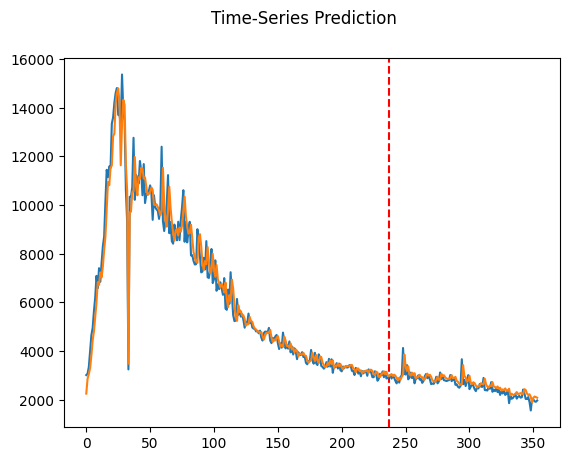

In [6]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [14]:
trueX = dataX
trueX
# true_data_length = len(trueX)
# for i in range(true_data_length, 413):
#     predict_y = lstm(trueX[:i])
#     trueX[i, 0, 0] = predict_y[-1]
# predict = trueX[1:, 0, 0]
# predict = predict.data.numpy()
# plt.plot(predict, 'r', label='pred')

tensor([[[0.0000],
         [0.0286],
         [0.0393],
         [0.0628]],

        [[0.0286],
         [0.0393],
         [0.0628],
         [0.1182]],

        [[0.0393],
         [0.0628],
         [0.1182],
         [0.1222]],

        ...,

        [[0.0392],
         [0.0143],
         [0.0486],
         [0.0464]],

        [[0.0143],
         [0.0486],
         [0.0464],
         [0.0411]],

        [[0.0486],
         [0.0464],
         [0.0411],
         [0.0398]]])